In [13]:
%matplotlib inline
import numpy as np
import glob
import matplotlib.pyplot as plt

## Testing Crosstalk from Streak

In [80]:
from matplotlib.colors import SymLogNorm
from matplotlib import colors

from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.spotTask import make_ccd_mosaic

from mixcoatl.crosstalk import make_stamp, crosstalk_fit, crosstalk_model, CrosstalkMatrix

infile = 'E2V-CCD250-112-09_spot_spot_640_20200616234354.fits'

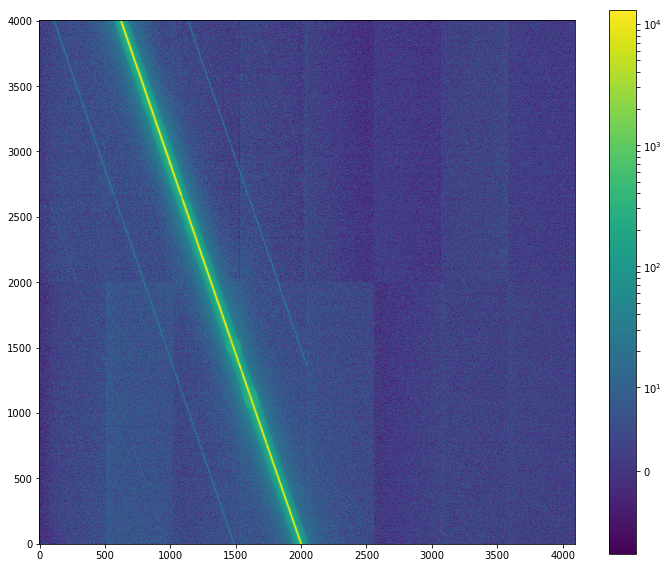

In [20]:
image = make_ccd_mosaic(infile)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im = ax.imshow(image.getArray(), origin='lower', norm=SymLogNorm(10, vmin=-10, vmax=13000))
fig.colorbar(im)

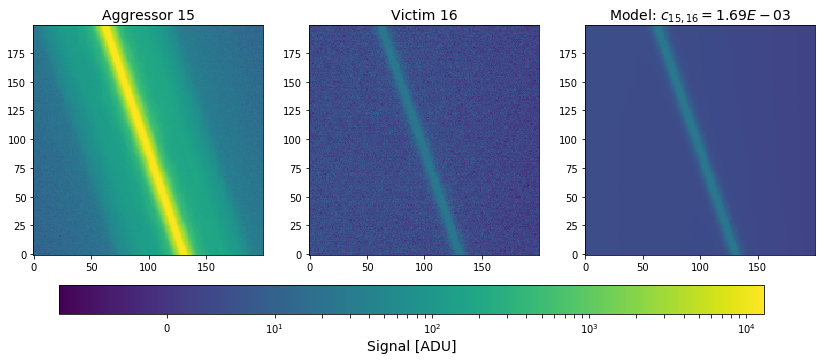

In [73]:
ccd = MaskedCCD(infile)

## Choose aggressor and victim
agg_amp = 15
aggarr = ccd.unbiased_and_trimmed_image(agg_amp).getImage().getArray()
vic_amp = 16
vicarr = ccd.unbiased_and_trimmed_image(vic_amp).getImage().getArray()

## Make stamps
l = 200
y, x = (150, 350)
aggressor_stamp = make_stamp(aggarr, y, x, l=l)
victim_stamp = make_stamp(vicarr, y, x, l=l)

## Best fit model
res = crosstalk_fit(aggressor_stamp, victim_stamp, num_iter=3, nsig=5.0, noise=7.0)
params = res[:4]
model = crosstalk_model(params, aggressor_stamp)

## Plot results
norm = SymLogNorm(10, vmin=-10, vmax=13000)

fig, axes = plt.subplots(1, 3, figsize=(14, 8))
im0 = axes[0].imshow(aggressor_stamp, origin='lower', norm=norm)
im1 = axes[1].imshow(victim_stamp, origin='lower', norm=norm)
im2 = axes[2].imshow(model, origin='lower', norm=norm)

axes[0].set_title(r'Aggressor {0}'.format(agg_amp), fontsize=14)
axes[1].set_title(r'Victim {0}'.format(vic_amp), fontsize=14)
axes[2].set_title(r'Model: $c_{{{0},{1}}}={2:.2E}$'.format(agg_amp, vic_amp, params[0]),
                  fontsize=14)

cbar_ax = fig.add_axes([0.15, 0.2, 0.7, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Signal [ADU]', fontsize=14)

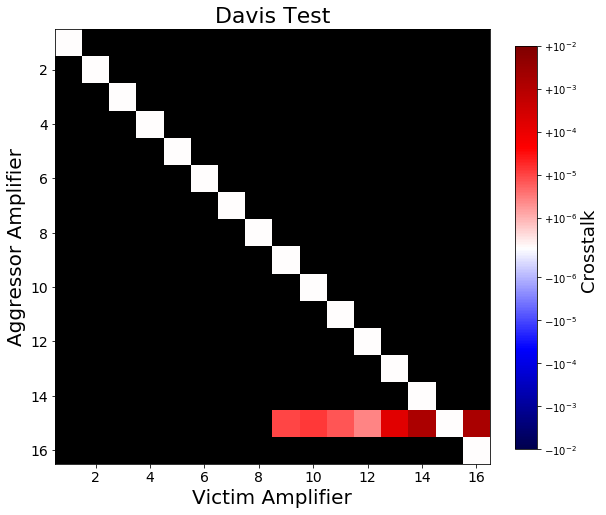

In [83]:
## Run analysis for a row
crosstalk_matrix = CrosstalkMatrix('Davis_test', namps=16)

i = 15
y, x = (150, 350)
imarr1 = ccd.unbiased_and_trimmed_image(i).getImage().getArray()
stamp1 = make_stamp(imarr1, y, x)
row = {}

## Calculate crosstalk for each victim amp
for j in [9, 10, 11, 12, 13, 14, 15, 16]:
    imarr2 = ccd.unbiased_and_trimmed_image(j).getImage().getArray()

    stamp2 = make_stamp(imarr2, y, x)
    row[j] = crosstalk_fit(stamp1, stamp2, noise=7.0)

crosstalk_matrix.set_row(i, row)
xtalk = crosstalk_matrix.matrix[0, :, :]
np.fill_diagonal(xtalk, 0.0)

cmap = plt.cm.seismic
cmap.set_bad(color='black')
norm = colors.SymLogNorm(1E-6, vmin=-1.E-2, vmax=1E-2)
cbar_ticks = [-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-1.0E-6, 1.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2]
cbar_ticklabels = [r'$-10^{-2}$', r'$-10^{-3}$', r'$-10^{-4}$', r'$-10^{-5}$', r'$-10^{-6}$',
                    r'$+10^{-6}$', r'$+10^{-5}$', r'$+10^{-4}$', r'$+10^{-3}$', r'$+10^{-2}$']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

im = ax.imshow(xtalk, norm=norm, cmap=cmap, interpolation='none', extent=(0.5, 16.5, 16.5, 0.5))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Aggressor Amplifier', fontsize=20)
ax.set_xlabel('Victim Amplifier', fontsize=20)
ax.set_title('{0}'.format('Davis Test'), fontsize=22)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                    ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticklabels)
cbar.set_label("Crosstalk ", size=18)